In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import Ridge


In [34]:
# data input
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])

# Model

In [59]:
test_data.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [69]:
# aggregate by date
train_data_aggdate = train_data.groupby('date')['num_sold'].sum().reset_index()
test_data_aggdate = test_data.groupby(['date'])['row_id'].sum().reset_index().drop(columns='row_id')

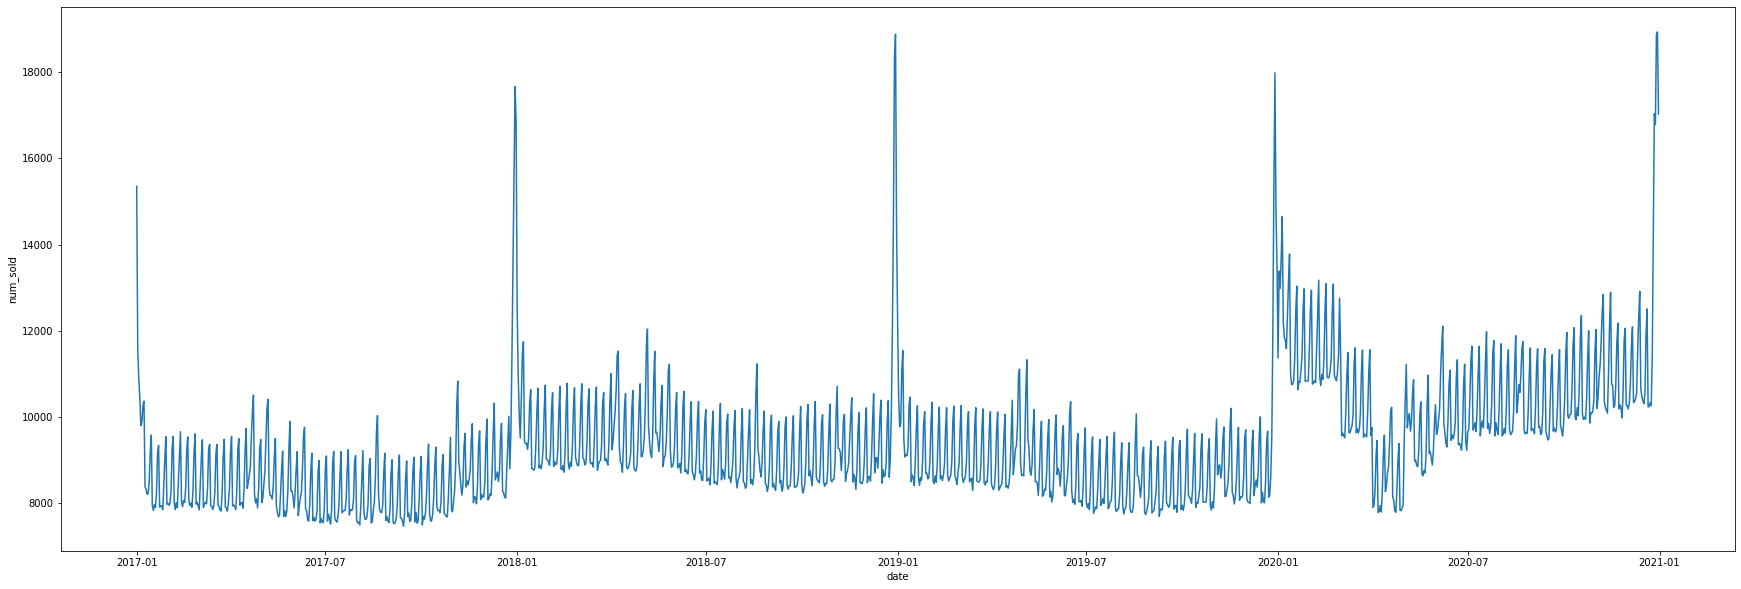

In [71]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=train_data_aggdate, x='date', y='num_sold')
plt.show()

About 2020:
1. The total sum of 2020 is higher than previous years
2. The pandamic period disrupt the several month sales (assuming March to May)

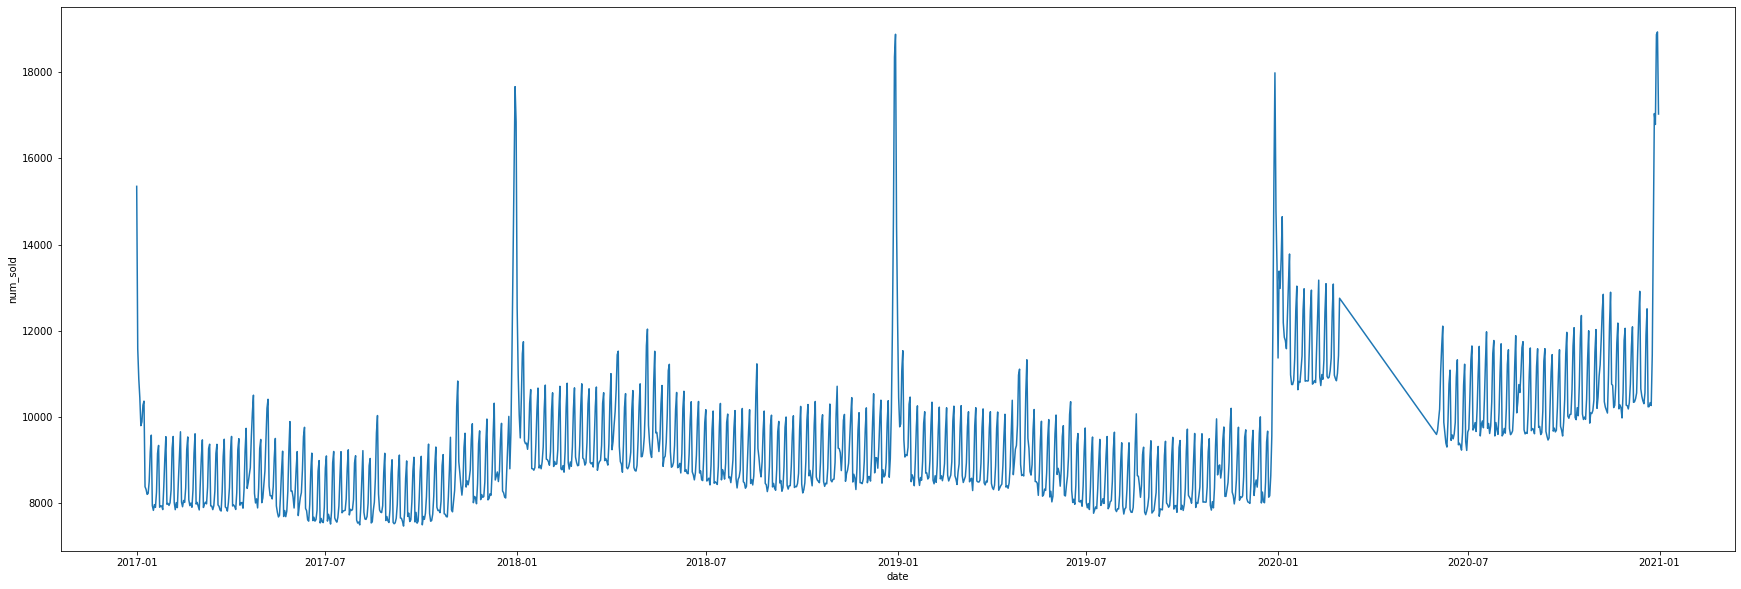

In [72]:
train_data_aggdate_nocovid = train_data_aggdate[ ~((train_data_aggdate['date'] >= "2020-03-01") & (train_data_aggdate['date'] < "2020-06-01"))]
plt.figure(figsize=(30, 10))
sns.lineplot(data=train_data_aggdate_nocovid, x='date', y='num_sold')
plt.show()

,month_sin,month_cos,year,important_dates_1,important_dates_2,important_dates_3,important_dates_4,important_dates_5,important_dates_6,important_dates_7,...,important_dates_361,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,5.000000e-01,0.866025,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.000000e-01,0.866025,2017,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.000000e-01,0.866025,2017,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,5.000000e-01,0.866025,2017,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5.000000e-01,0.866025,2017,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-2.449294e-16,1.000000,2020,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1457,-2.449294e-16,1.000000,2020,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1458,-2.449294e-16,1.000000,2020,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1459,-2.449294e-16,1.000000,2020,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [93]:
test_data_pred

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
360   2021-12-27
361   2021-12-28
362   2021-12-29
363   2021-12-30
364   2021-12-31
Name: date, Length: 365, dtype: datetime64[ns]

In [64]:
def feature_engineer(df):
    new_df = df.copy()
    new_df['month'] = new_df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi/12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi/12))
    
    new_df['day_of_week'] = df['date'].dt.dayofweek
    new_df['day_of_year'] = df['date'].dt.dayofyear
    
    new_df['year'] = df['date'].dt.year
    
    new_df['important_dates'] = new_df['day_of_year'].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,363,364,365] else 0)
    new_df = new_df.drop(columns=['date', 'month', 'day_of_year'])
    
    new_df = pd.get_dummies(new_df, columns=['important_dates', 'day_of_week'], drop_first=True)
    
    return new_df
    
    

In [73]:
train_data_trans = feature_engineer(train_data_aggdate_nocovid)
test_data_trans = feature_engineer(test_data_aggdate)

In [77]:
test_data_trans.head()

,month_sin,month_cos,year,important_dates_1,important_dates_2,important_dates_3,important_dates_4,important_dates_5,important_dates_6,important_dates_7,...,important_dates_361,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,0.5,0.866025,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.5,0.866025,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.5,0.866025,2021,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.5,0.866025,2021,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.5,0.866025,2021,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [79]:
X_train = train_data_trans.drop(columns='num_sold')
y_train = train_data_trans['num_sold']
X_test = test_data_trans

In [109]:
# keep the test dates
test_data_pred = test_data.groupby(['date']).first().reset_index()[['date']]

Define and train the model

In [83]:
model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model.fit(X_train, y_train)

Ridge(max_iter=1000000, random_state=0, tol=0.01)

In [84]:
pred = model.predict(X_test)

In [111]:
test_data_pred['num_sold'] = pred

In [116]:
full_data = pd.concat([train_data_aggdate, test_data_pred]).reset_index(drop=True)

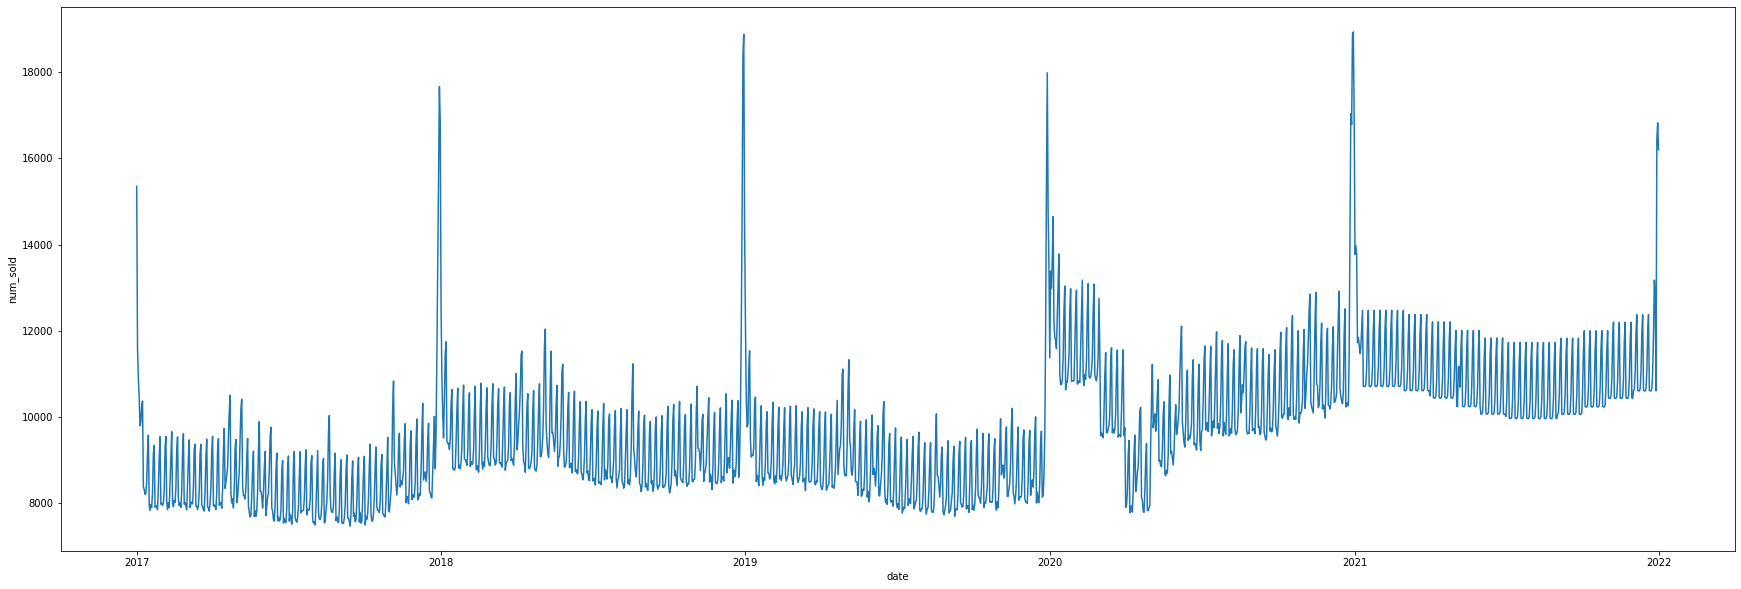

In [118]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=full_data, x='date', y='num_sold')
plt.show()